In [1]:
import matplotlib.pyplot as plt
import os
from os.path import join
import numpy as np
from PIL import Image
import matplotlib.image as mpimg
from skimage.color import rgb2gray
from skimage.color import label2rgb
from skimage.filters import gaussian
from sklearn.cluster import KMeans

In [17]:
import warnings
warnings.filterwarnings("ignore")

In [18]:
plt.close('all')
clear = lambda: os.system('clear')
clear()
np.random.seed(110)

colors = [[1,0,0],[0,1,0],[0,0,1],[0,0.5,0.5],[0.5,0,0.5]]
imgNames = ['water_coins','jump','tiger']
segmentCounts = [2,3,4,5]

In [19]:
## define functions required for processing
def normalize(img):
    """ min-max normalization """
    h = img.shape[0]
    w = img.shape[1]
    nc = img.shape[2]
    new_img = np.zeros((h,w,nc),dtype='float')
    for cc in range(nc):
        new_img[:,cc] = (img[:,cc] - img[:,cc].min()) / (img[:,cc].max() - img[:,cc].min())
    return(new_img)

In [20]:
def im2double(im):
    try:
        info = np.iinfo(im.dtype) # Get the data type of the input image
        return im.astype(np.float) / info.max # Divide all values by the largest possible value in the datatype
    except ValueError:
        print('Image is of type Double-- No conversion required')
        return im.astype(np.float)

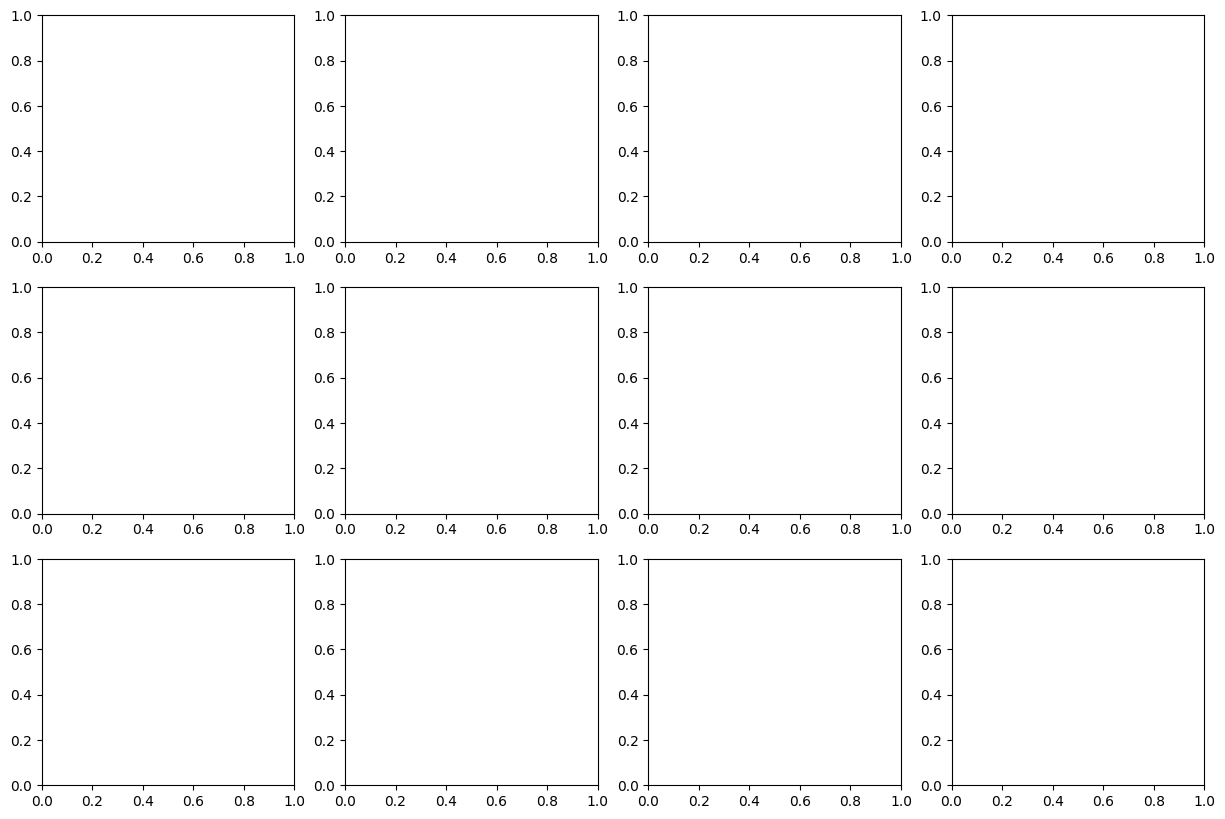

In [21]:
# final plot
fig, axs = plt.subplots(3, 4, figsize=(15,10))

In [ ]:
for imgName in imgNames:
    for SegCount in segmentCounts:
        # Load the image using the Matplotlib image library
        img_path = os.path.join("input", imgName + ".png")
        img = plt.imread(img_path)
        print('Using Matplotlib Image Library: Image is of datatype ',img.dtype,'and size ',img.shape) # Image is of type float

        # Load image using the Pillow 
        img_path = os.path.join("input", imgName + ".png")
        img = Image.open(img_path)
        img = np.array(img) 
        print('Using Pillow (Python Image Library): Image is of datatype ', img.dtype, 'and size ', img.shape)  # Image is of type uint8

        # Defining parameters
        nSegments = SegCount # of color clusters in image
        nPixels = img.shape[0] * img.shape[1] # h* w
        maxIterations = 20;
        nColors = 3;
        
        # Determine the output path for writing images to files
        outputPath = join(''.join(["Output/",str(SegCount), "_segments/",  imgName , "/"]));
        if not(os.path.exists(outputPath)):
            os.makedirs(outputPath)

        # save image in output folder with png extension 
        output_file = os.path.join(outputPath, '0.png')
        mpimg.imsave(output_file, img)

        # reshaping
        pixels = img
        h, w, nColors = pixels.shape
        pixels = pixels.reshape(nPixels, nColors, 1)

        # initialising pi vector, mu matrix 
        pi = 1/nSegments*(np.ones((nSegments, 1),dtype='float'))
        increment = np.random.normal(0,.0001,1)
        for seg_ctr in range(len(pi)):
            if(seg_ctr%2==1):
                pi[seg_ctr] = pi[seg_ctr] + increment
            else:
                pi[seg_ctr] = pi[seg_ctr] - increment

        
        # Initialize mu to 1/nSegments*['ones' matrix (whose elements are all 1) of size nSegments X nColors
        # get R, G, B values
        R = np.mean(img[:,:,0])
        G = np.mean(img[:,:,1])
        B = np.mean(img[:,:,2])
        RGB_matrix = np.array([R, G, B])

        # Initialize mu to 1/nSegments*['ones' matrix(whose elements are all 1) of size nSegments X nColors 
        mu = (1/nSegments) * np.ones((nSegments, nColors)) * RGB_matrix
        # add noise
        for seg_ctr in range(nSegments):
            if(seg_ctr%2==1):
                increment = np.random.normal(0,.0001,1)
            for col_ctr in range(nColors):
                if(seg_ctr%2==1):
                    mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) + increment
                else:
                    mu[seg_ctr,col_ctr] = np.mean(pixels[:,col_ctr]) -increment;
        


        #%% EM-iterations begin here. Start with the initial (pi, mu) guesses 
        mu_last_iter = mu;
        pi_last_iter = pi;

        for iteration in range(maxIterations):
            print(''.join(['Image: ',imgName,' nSegments:',str(nSegments),' iteration:',str(iteration+1), ' E-step']))
            # weights that describe the likelihood that pixel denoted by pix_import scipy.miscctr" belongs to a color cluster "seg_ctr" 
            Ws = np.ones((nPixels,nSegments),dtype='float') # temporarily reinitialize all weights to 1, before they are recomputed
            # logarithmic form of the E step
            for pix_ctr in range(nPixels):
            # Calculate Ajs
                logAjVec = np.zeros((nSegments,1),dtype='float')
                for seg_ctr in range(nSegments):
                    x_minus_mu_T = np.transpose(pixels[pix_ctr,:]-(mu[seg_ctr,:])[np.newaxis].T)
                    x_minus_mu = ((pixels[pix_ctr,:]-(mu[seg_ctr,:])[np.newaxis].T))
                    logAjVec[seg_ctr] = np.log(pi[seg_ctr]) - .5*(np.dot(x_minus_mu_T,x_minus_mu))
                    # Note the max 
                    logAmax = max(logAjVec.tolist())
                    # Calculate the third term from the final eqn in the above link 
                    thirdTerm = 0;
                    for seg_ctr in range(nSegments):
                        thirdTerm = thirdTerm + np.exp(logAjVec[seg_ctr]-logAmax)
                    # Here Ws are the relative membership weights(p_i/sum(p_i)),but computed in a round-about way 
                    for seg_ctr in range(nSegments):
                        logY = logAjVec[seg_ctr] - logAmax - np.log(thirdTerm)
                        Ws[pix_ctr][seg_ctr] = np.exp(logY)

            # ----------------- M-step ------------------

            print(''.join(['Image: ',imgName,' nSegments: ',str(nSegments),'iteration: ',str(iteration+1), ' M-step: Mixture coefficients']))
            # Temporarily reinitialize mu and pi to 0, before they are␣recomputed 
            mu = np.zeros((nSegments,nColors),dtype='float') # mean color for␣each segment
            pi = np.zeros((nSegments,1),dtype='float') #mixture coefficients
            
            for seg_ctr in range(nSegments):
                denominatorSum = 0
                for pix_ctr in range(nPixels):
                    mu[seg_ctr] += pixels[pix_ctr].flatten() * Ws[pix_ctr][seg_ctr]
                    denominatorSum += Ws[pix_ctr][seg_ctr]

                ## Update mu 
                mu[seg_ctr,:] = mu[seg_ctr,:]/ denominatorSum;
                ## Update pi 
                pi[seg_ctr] = denominatorSum / nPixels; #sum of weights (each weight is a probability) for given segment/total num of pixels
            print(np.transpose(pi))

            muDiffSq = np.sum(np.multiply((mu - mu_last_iter),(mu - mu_last_iter)))
            piDiffSq = np.sum(np.multiply((pi - pi_last_iter),(pi - pi_last_iter)))
            
            if (muDiffSq < .0000001 and piDiffSq < .0000001): #sign of convergence
                print('Convergence Criteria Met at Iteration: ',iteration, '--Exiting code')
                break;
            
            mu_last_iter = mu;
            pi_last_iter = pi;
            # Draw the segmented image using the mean of the color cluster as the RGB value for all pixels in that cluster 
            segpixels = np.array(pixels)
            cluster = 0
            for pix_ctr in range(nPixels):
                cluster = np.where(Ws[pix_ctr,:] == max(Ws[pix_ctr,:]))
                vec = np.squeeze(np.transpose(mu[cluster,:]))
                segpixels[pix_ctr,:] = vec.reshape(vec.shape[0],1)
            
            # Save segmented image at each iteration
            segpixels = np.reshape(segpixels,(img.shape[0],img.shape[1],nColors)) ## reshape segpixels to obtain R,G, B image
            # Convert segpixels to grayscale 
            segpixels = rgb2gray(segpixels) * 255  # range [0,255]
            segpixels = segpixels.astype(np.uint8)  # Convert to uint8 type
            # Reshape the grayscale image for kmeans computation(2D array) 
            reshaped_for_kmean = segpixels.reshape(-1, 1)

            # k-means 
            kmeans = KMeans(n_clusters=nSegments).fit(reshaped_for_kmean)

            # reshape kmeans.labels_ 
            seglabels = kmeans.labels_.reshape(segpixels.shape)

            # seglabels with specified colors 
            temp_labels = label2rgb(seglabels, colors=colors)
            # gaussian smoothing and sigma 2 
            temp_labels = gaussian(temp_labels, sigma=2)
            # range [0,1]  
            seglabels = np.clip(temp_labels, a_min=0, a_max=1)

            # save
            mpimg.imsave(''.join([outputPath,str(iteration+1),'.png']),seglabels) 
               
        if iteration < 20:
            final_iteration = iteration
        else:
            final_iteration = 20
        output_path_final = ''.join([outputPath, str(final_iteration), '.png'])
        
        if not os.path.exists(output_path_final):
            output_path_final = ''.join([outputPath, str(iteration), '.png'])
        
        segmented_img = plt.imread(output_path_final)

        # Displaying the output grid 
        axs[imgNames.index(imgName), segmentCounts.index(SegCount)].imshow(segmented_img)
        axs[imgNames.index(imgName), segmentCounts.index(SegCount)].axis('off')
        axs[imgNames.index(imgName), segmentCounts.index(SegCount)].set_title(f'{imgName} - {SegCount} Segment')

plt.tight_layout()
plt.show()

Using Matplotlib Image Library: Image is of datatype  float32 and size  (312, 252, 3)
Using Pillow (Python Image Library): Image is of datatype  uint8 and size  (312, 252, 3)
Image: water_coins nSegments:2 iteration:1 E-step
Image: water_coins nSegments: 2iteration: 1 M-step: Mixture coefficients
[[0.49996714 0.50003286]]
Image: water_coins nSegments:2 iteration:2 E-step
Image: water_coins nSegments: 2iteration: 2 M-step: Mixture coefficients
[[0.44622235 0.55377765]]
Image: water_coins nSegments:2 iteration:3 E-step
Image: water_coins nSegments: 2iteration: 3 M-step: Mixture coefficients
[[0.44233313 0.55766687]]
Image: water_coins nSegments:2 iteration:4 E-step
Image: water_coins nSegments: 2iteration: 4 M-step: Mixture coefficients
[[0.4420263 0.5579737]]
Image: water_coins nSegments:2 iteration:5 E-step
Image: water_coins nSegments: 2iteration: 5 M-step: Mixture coefficients
[[0.4419647 0.5580353]]
Image: water_coins nSegments:2 iteration:6 E-step
Image: water_coins nSegments: 2ite